# Using Google's Causal Impact library (TensorFlow implementation)

## Intro

In this notebook I will be showing use case of Google's Causal Impact Library Python implementation using Tensorflow Probability library. 

The case study that we are going to look at is an event of Bitcoin stock purchase by Tesla. On February 8, 2021, Tesla revealed that it had purchased $1.5 billion of Bitcoin, totaling 7.5% of the company’s cash, and that it planned to accept payments in the cryptocurrency soon. The hypothesis we are going to check is whether it has influenced the bitcoin price.

## Information about Causal Impact

**CausalImpact** R package (developed by Google: http://google.github.io/CausalImpact/) generalizes difference-in-differences approach to the time-series setting by modelling the counterfactual of a time series observed both before and after the intervention. It provides a fully Bayesian time-series estimate for the effect; and it uses model averaging to construct the most appropriate synthetic control for modelling the counterfactual.

Bayesian Structural Time Series models can be expressed by the following equations:

$$y_t = Z^T_t\alpha_t + \beta X_t + G_t\epsilon_t$$
$$a_{t+1} = T_t\alpha_t + R_t\eta_t$$
$$\epsilon_t \sim \mathcal{N}(0, \sigma_t^2)$$
$$\eta_t \sim \mathcal{N}(0, Q_t)$$

The $a$ is also referred as a "state" of the series and $y_t$ is a linear combination of the states plus a linear regression with the covariates $X$ (and the measurement noise $\epsilon$ that follows a zero-mean normal distribution). By varying the matricex $Z$, $T$, $G$ and $R$ we can model several distinct behaviors for the time series (including the more well known such as ARMA or ARIMA).

The main idea is to use the predictions of the fitted model as a reference to what probably would had been observed with no intervention taking place.

In this package, you can choose any time series model you want to fit your data. If no model is used as input, a local level model is built by default:

$$ y_t = \mu_t + \gamma_t + \beta X_t + \epsilon_t$$
$$ \mu_{t+1} = \mu_t +  \eta_{\mu, t}$$

Any given point in time is modeled first by a random walk component $\mu_t$, also known as the "local level" component, which increases as the other arguments doesn't add much signal into explaining the data (as it models just randomness, there's no information being added with this component except the expectation for greater uncertainty) along with the $\gamma_t$ variable which models seasonal components

Finally we have the component $\beta X_t$ which is a linear regression of covariates that further helps to explain observed data. The better this component works into the prediction task, the lower the local level component should be.

The parameter $\epsilon_t$ models noise related to measuring $y_t$ and it follows a normal distribution with zero mean and $\sigma_{\epsilon}$ standard deviation.

## Advantages:
- Provides with a point estimate of intervention effect for each datapoint in the post-period.
- Provides with absolute / relative (%) impact and credible intervals for pre-selected significance level.

## Disadvantages:
* Cannot work with raw panel data (multiple observation of same unit over the experiment timeframe). The workaround is to either use matched pairs (site vs. site) or use data aggregated across the group.

**For more technical details refer to the following materials:**

* Publication: https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf

* Official documentation (for R implementation): 
https://google.github.io/CausalImpact/CausalImpact.html

* Python implementation using TF probability: https://github.com/WillianFuks/tfcausalimpact

## Import libraries

In [1]:
%pip install yfinance
%pip install tfcausalimpact

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 229.7 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 1.2 MB/s eta 0:00:000:00:010:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.2.1
    Uninstalling pytz-2022.2.1:
      Successfully uninstalled pytz-2022.2.1
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 MB 447.5 kB/s eta 0:00:00m eta 0:00:010:00:13
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 384.2 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 401.3 kB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 537.4 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━

In [2]:
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact

2023-01-22 15:21:18.492915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
## Exporting stock data from Yahoo Finance database by means of yfinance library

In [56]:
## Defining period for stock data

training_start = '2020-12-01'
training_end = '2021-02-05'
treatment_start = '2021-02-08'
treatment_end = '2021-02-09'
end_stock ='2021-02-10'

In [42]:
## Bitcoin data
y = ['BTC-USD'] # bitcoin price
y = yf.download(y,
               start = training_start,
               end = end_stock,
               interval = '1d',
               ignore_tz=True
               )

y = y['Adj Close'].rename('Bitcoin')
y

[*********************100%***********************]  1 of 1 completed


Date
2020-12-01    18802.998047
2020-12-02    19201.091797
2020-12-03    19445.398438
2020-12-04    18699.765625
2020-12-05    19154.230469
                  ...     
2021-02-05    38144.308594
2021-02-06    39266.011719
2021-02-07    38903.441406
2021-02-08    46196.464844
2021-02-09    46481.105469
Name: Bitcoin, Length: 71, dtype: float64

In [43]:
stocks = ['CARL-B.CO','ZAL.DE','SQ','CRSP','TRMB','JD','DE','KTOS','GOOG'] 
X = yf.download(stocks,
                start = training_start,
                end = end_stock,
                period = '1d',
                ignore_tz=True)
X.head()

[*********************100%***********************]  9 of 9 completed


Adj Close                                                \
             CARL-B.CO        CRSP          DE       GOOG         JD   
Date                                                                   
2020-12-01  881.149170  129.580002  248.537613  89.904999  83.259346   
2020-12-02  889.692993  131.539993  252.307632  91.397499  82.303459   
2020-12-03  887.224731  140.460007  246.150894  91.338501  84.166458   
2020-12-04  893.869934  147.539993  246.842560  91.399498  83.093529   
2020-12-07  884.187012  149.720001  245.498230  90.973999  81.435364   

                                                              Close  ...  \
                 KTOS          SQ       TRMB     ZAL.DE   CARL-B.CO  ...   
Date                                                                 ...   
2020-12-01  21.480000  203.000000  60.730000  82.300003  928.200012  ...   
2020-12-02  21.670000  202.000000  60.669998  81.220001  937.200012  ...   
2020-12-03  22.299999  205.529999  61.009998  80.059998  934.599976  ...   
2020-12-04  23.100000  208.149994  63.020000  78.779999  941.599976  ...   
2020-12-07  23.469999  212.580002  63.080002  79.040001  931.400024  ...   

                 Open    Volume                                                \
               ZAL.DE CARL-B.CO       CRSP         DE        GOOG          JD   
Date                                                                            
2020-12-01  85.379997  201903.0  1727900.0  2086400.0  34738000.0  10878100.0   
2020-12-02  82.500000  236435.0  1044800.0  2773200.0  24440000.0  12434400.0   
2020-12-03  81.239998  233180.0  1777100.0  2079900.0  24546000.0   7929400.0   
2020-12-04  80.139999  267925.0  2089600.0  1655000.0  27564000.0   9411000.0   
2020-12-07  78.000000  189586.0  4274400.0  1598400.0  26418000.0  12677500.0   

                                                       
                KTOS          SQ       TRMB    ZAL.DE  
Date                                                   
2020-12-01  551500.0  10795900.0  1777200.0  518547.0  
2020-12-02  641800.0  10483700.0   890900.0  534284.0  
2020-12-03  619700.0   6918200.0   647600.0  406232.0  
2020-12-04  931500.0   6566200.0   778800.0  503088.0  
2020-12-07  930200.0   5895300.0   554100.0  616147.0  

[5 rows x 54 columns]

In [44]:
# data cleaning / transformations
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X = X.dropna()
X.head()

,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-12-01,881.149170,129.580002,248.537613,89.904999,83.259346,21.480000,203.000000,60.730000,82.300003
2020-12-02,889.692993,131.539993,252.307632,91.397499,82.303459,21.670000,202.000000,60.669998,81.220001
2020-12-03,887.224731,140.460007,246.150894,91.338501,84.166458,22.299999,205.529999,61.009998,80.059998
2020-12-04,893.869934,147.539993,246.842560,91.399498,83.093529,23.100000,208.149994,63.020000,78.779999
2020-12-07,884.187012,149.720001,245.498230,90.973999,81.435364,23.469999,212.580002,63.080002,79.040001


In [45]:
dataset = pd.concat([y,X],axis=1).dropna()
dataset.head()

,Bitcoin,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2020-12-01,18802.998047,881.149170,129.580002,248.537613,89.904999,83.259346,21.480000,203.000000,60.730000,82.300003
2020-12-02,19201.091797,889.692993,131.539993,252.307632,91.397499,82.303459,21.670000,202.000000,60.669998,81.220001
2020-12-03,19445.398438,887.224731,140.460007,246.150894,91.338501,84.166458,22.299999,205.529999,61.009998,80.059998
2020-12-04,18699.765625,893.869934,147.539993,246.842560,91.399498,83.093529,23.100000,208.149994,63.020000,78.779999
2020-12-07,19191.630859,884.187012,149.720001,245.498230,90.973999,81.435364,23.469999,212.580002,63.080002,79.040001


In [47]:
## Exploring if there was any existing correlation prior to the treatment.

dataset_correlation = dataset[dataset.index <= training_end]
dataset_correlation.tail()

,Bitcoin,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2021-02-01,33537.175781,864.061584,165.679993,285.477142,95.067497,89.023895,27.010000,221.940002,67.720001,95.940002
2021-02-02,35510.289062,879.820129,168.149994,295.569092,96.375504,93.071770,27.920000,227.630005,70.809998,95.379997
2021-02-03,37472.089844,878.111389,164.500000,294.201355,103.503502,93.149803,28.629999,227.940002,70.599998,97.820000
2021-02-04,36926.066406,884.756531,167.789993,302.144043,103.118500,92.301208,29.330000,237.720001,71.430000,97.239998
2021-02-05,38144.308594,915.893860,168.809998,302.114746,104.900002,94.261749,29.290001,240.380005,72.269997,98.500000


In [51]:
# we will take percentage change instead of raw values which should give us clearer picture.

dataset_correlation.pct_change().dropna().corr()

,Bitcoin,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Bitcoin,1.000000,0.325318,0.201920,0.232180,0.224383,0.045750,0.073752,0.421975,0.193557,0.298174
CARL-B.CO,0.325318,1.000000,-0.114138,0.131608,0.372021,0.441814,0.191891,0.223079,0.296426,0.342812
CRSP,0.201920,-0.114138,1.000000,0.233255,0.050452,-0.029193,0.362913,0.499657,0.406307,-0.136829
DE,0.232180,0.131608,0.233255,1.000000,0.253445,0.064187,0.321049,0.435228,0.538002,0.099686
GOOG,0.224383,0.372021,0.050452,0.253445,1.000000,0.327818,0.173595,0.214138,0.396960,0.122945
JD,0.045750,0.441814,-0.029193,0.064187,0.327818,1.000000,0.056969,0.270720,0.229107,0.280486
KTOS,0.073752,0.191891,0.362913,0.321049,0.173595,0.056969,1.000000,0.227508,0.220440,0.002723
SQ,0.421975,0.223079,0.499657,0.435228,0.214138,0.270720,0.227508,1.000000,0.354326,0.112679
TRMB,0.193557,0.296426,0.406307,0.538002,0.396960,0.229107,0.220440,0.354326,1.000000,0.107210
ZAL.DE,0.298174,0.342812,-0.136829,0.099686,0.122945,0.280486,0.002723,0.112679,0.107210,1.000000


Pretty weak correlation is observed. We will take those stock tickers where correlation coefficient is to Bitcoin is >=0.15. These stocks will act as possible controls. 

In [52]:
dataset = dataset[['Bitcoin','CARL-B.CO','DE','GOOG','SQ','TRMB','ZAL.DE']]

## Causal Impact

In [69]:
## define pre and post perios
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

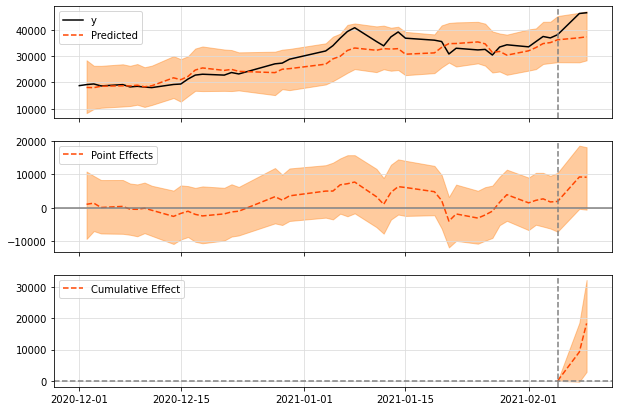

In [70]:
# Causal Impact
impact = CausalImpact(
    data = dataset, 
    pre_period = pre_period,
    post_period = post_period
)
impact.plot()

In [71]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    46338.79           92677.57
Prediction (s.d.)         37160.64 (3926.85) 74321.28 (7853.69)
95% CI                    [29450.41, 44843.37][58900.82, 89686.74]

Absolute effect (s.d.)    9178.14 (3926.85)  18356.29 (7853.69)
95% CI                    [1495.42, 16888.38][2990.83, 33776.75]

Relative effect (s.d.)    24.7% (10.57%)     24.7% (10.57%)
95% CI                    [4.02%, 45.45%]    [4.02%, 45.45%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.4%

For more details run the command: print(impact.summary('report'))


Let's explore fit metrics:

In [72]:
print("model args/error/residuals")
print(impact.model_args)

y = 'Bitcoin'
df_j = impact.pre_data.join(impact.inferences)
mae = abs(df_j["complete_preds_means"] - df_j[y]).mean()
mape = abs(df_j["complete_preds_means"] - df_j[y]).sum() / df_j[y].sum()
print(f"mae={mae}, mape={mape}")
print(f"average error={(df_j['complete_preds_means']- df_j[y]).mean()}")

model args/error/residuals
{'standardize': True, 'prior_level_sd': 0.01, 'niter': 1000, 'fit_method': 'vi', 'nseasons': 1, 'season_duration': 1}
mae=2791.452392578125, mape=0.09644296765327454
average error=-1568.4708251953125


**Observations**

* There is a statistically significant evidence (p-value = 0.01) that Bitcoin price increased after Tesla's investment, and estimated relative effect is 25.6% with [5.77%,46.6%] 95% Credibility Interval. 
* One should note that pre-treatment fit is far from being accurate (2791 MAE, 9% MAPE). 

### Experimenting with bayesian timeseries fit
By default, fit method for is variational inference (`model_args = {'fit_method' : 'vi'}`). Let's try Hamiltonian Monte Carlo fit method which is claimed to yield more accurate results.


/Users/narmina/.pyenv/versions/env-3.8.10/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


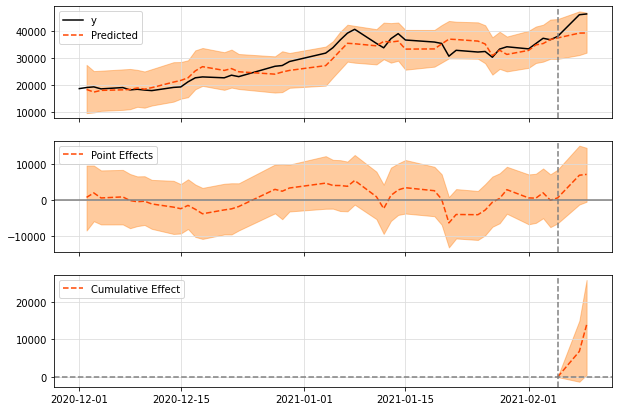

In [73]:
# Causal Impact
impact = CausalImpact(
    data = dataset, 
    pre_period = pre_period,
    post_period = post_period,
    model_args = {'fit_method' : 'hmc'}
)
impact.plot()

In [74]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    46338.79           92677.57
Prediction (s.d.)         39412.14 (3401.07) 78824.29 (6802.13)
95% CI                    [32950.0, 46281.94][65900.01, 92563.89]

Absolute effect (s.d.)    6926.64 (3401.07)  13853.28 (6802.13)
95% CI                    [56.84, 13388.78]  [113.68, 26777.56]

Relative effect (s.d.)    17.57% (8.63%)     17.57% (8.63%)
95% CI                    [0.14%, 33.97%]    [0.14%, 33.97%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.7%

For more details run the command: print(impact.summary('report'))


In [75]:
print("model args/error/residuals")
print(impact.model_args)

y = 'Bitcoin'
df_j = impact.pre_data.join(impact.inferences)
mae = abs(df_j["complete_preds_means"] - df_j[y]).mean()
mape = abs(df_j["complete_preds_means"] - df_j[y]).sum() / df_j[y].sum()
print(f"mae={mae}, mape={mape}")
print(f"average error={(df_j['complete_preds_means']- df_j[y]).mean()}")

model args/error/residuals
{'fit_method': 'hmc', 'standardize': True, 'prior_level_sd': 0.01, 'niter': 1000, 'nseasons': 1, 'season_duration': 1}
mae=2349.1748046875, mape=0.08116254210472107
average error=-459.3229675292969


Here we observe much better fit on pre-treatment period and much smaller effect being estimated by the model (~16%). 